<a href="https://colab.research.google.com/github/TreePlayer14/Codigo-TCC/blob/main/Codigo_TCC_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Handling:

In [ ]:
from PIL import Image
from pandas import DataFrame
import os 

class Arff:
    """Structure that holds an arff file
    
        Attrs:
            relation (string): File content description.
            attrs (list of strings): List of attribute names.
            attr_types (list of strings): List of attribute types.
            entries (list of lists): Arff data.
            classes (list of int): Classes on the file.
    """
    def __init__(self):
        self.relation = ""
        self.attrs = []
        self.attr_types = []
        self.entries = []
        self.classes = []

    def __len__(self):
        return len(self.entries)

def readImage(path):
    """Open an image using PIL"""
    try:
        return Image.open(path)
    except OSError as err:
        print("Couldn't read file. Error: {0}".format(err))

def createFolderContentCsv(folder_path: str, csv_name:str, extension:str=None):
    """Create a csv file with the contents of a folder
        Args:
            folder_path(string): path to folder
            csv_name(string): output csv file name, without extension
            extension(string): filter only files of a kind on the output csv. 
    """
    if os.path.isdir(folder_path):
        output_file_path = os.path.join(folder_path,csv_name)+'.csv'
        if os.path.isfile(output_file_path):
            print("There's already a csv file with given name. name: {}".format(csv_name))
            return

        content_list = os.listdir(folder_path)
        file_list = []
        for content in content_list:
            if os.path.isfile(os.path.join(folder_path, content)):
                file_list.append(content)
        if extension:
            temp_list = []
            for f in file_list:
                if f.endswith(extension):
                    temp_list.append(f)
            file_list = temp_list
        
        df = DataFrame(file_list)
        df.to_csv(output_file_path, header=False, index=False)
    else:
        print("Folder doesn't exist. path: {}".format(folder_path))

def createArffFile(file_name: str, content: list, attrs: list, classes: list, target:str = None):
    """Create a arff file with given data list
        Args:
            file_name(string): name of output file without extension
            content(list): data to write in arff, must be a two-dimensional list. Function assumes all values are real numbers
            attrs(list): list with the attribute names for the content. Classes are not included here, and should be put at the end of the each content entry
            classes(list): list with possible classes of given data
            target(string): path to the target folder of the output file, if none is passed assumes the current directory   
    """
    if target == None:
        target = os.getcwd()
    
    output_path = os.path.join(target,file_name) + ".arff"

    if os.path.isfile(output_path):
        raise Exception("There's already a file with given name at target folder. File name: {}" .format(file_name))

    line_count = len(content)

    if line_count == 0:
        raise Exception("The content list is empty!")

    attr_count = len(content[0])

    if len(classes) == 0:
        raise Exception("Must send at least one class!")

    if attr_count == 0:
        raise Exception("Didn't find values for any attribute on the content list")
    elif attr_count-1 != len(attrs):
        raise Exception("Mismatching size of attribute name list and received content. Found {} atributes and {} names".format(attr_count-1,len(attrs)))

    f = open(output_path, "x")
    f.write("@RELATION '" + file_name + ".arff'\n\n")

    for name in attrs:
        f.write("@ATTRIBUTE " + name + " numeric\n")

    classes_as_strings = [str(x) for x in classes]
    joined_classes = ",".join(classes_as_strings)

    f.write("@ATTRIBUTE class {" + joined_classes + "}\n\n")
    f.write("@DATA\n\n")

    for entry in content:
        content_as_string = [str(x) for x in entry]
        joined_content = ",".join(content_as_string)
        f.write(joined_content+"\n")
    
    f.close()
    
def readArff(path:str):
    """Reads the content of an arff file to and arff object
    
    Args:
        path(str): Arff file path.

    Returns:
        Arff type object
    """
    if os.path.isfile(path) == False:
        raise Exception("File doesn't exist. path: {}".format(path))

    obj = Arff()

    f = open(path, "r")
    line = f.readline()
    reading_entries = False
    while line != '':
        # skips line breaks
        if line == "\n":
            line = f.readline()
            continue

        # clean text
        line = line.strip()

        if reading_entries:
            entries = line.split(",")
            if len(entries) != (len(obj.attrs) + 1):
                raise Exception("Found entry with more data than specified attributes!")
            
            entry_list = []
            for idx in range(len(obj.attr_types)):
                if obj.attr_types[idx].lower() == "numeric" or obj.attr_types[idx].lower() == "real":
                    entry_list.append(float(entries[idx]))
                else:
                    entry_list.append(entries[idx])
                    
            #gets class at the end
            entry_class = int(entries[-1])
            if entry_class not in obj.classes:
                raise Exception("Read entry with a class different from the ones especified. \nExpected: {}\nGot: {}".format(obj.classes, entry_class))
            entry_list.append(entry_class)

            if len(obj) == 0:
                obj.entries = [entry_list]
            else:
                obj.entries.append(entry_list)
        else:
            if line.lower().startswith("@relation"):
                splitted_line = line.split(" ")
                obj.relation = splitted_line[1].replace("'","")
            elif line.lower().startswith("@attribute"):
                splitted_line = line.split(" ")
                if splitted_line[1].lower() == 'class':
                    classes = splitted_line[2].replace("{","").replace("}","")
                    obj.classes = [int(num) for num in classes.split(",")]
                else:
                    obj.attrs.append(splitted_line[1])
                    obj.attr_types.append(splitted_line[2])
            elif line.lower().startswith("@data"):
                reading_entries = True

        line = f.readline() 
    
    f.close()

    return obj

def mergeArffs(arff1:Arff, arff2: Arff):
    """Combine two arff objects into one and write it to a target

    Args:
        arff1(Arff): First arff.
        arff2(Arff): Second arff.

    Returns:
        Combined Arff object 
    """
    if len(arff1) != len(arff2):
        raise Exception("Can't combine arffs with different data length.")

    if arff1.classes != arff2.classes:
        raise Exception("Can't combine arffs with different classes.")

    combined = Arff()
    combined.classes = arff1.classes
    combined.relation = "Merged_{}_and_{}".format(arff1.relation,arff2.relation)
    combined.attrs = arff1.attrs + arff2.attrs
    combined.attr_types = arff1.attr_types + arff2.attr_types
    for idx in range(len(arff1)):
        if arff1.entries[idx][-1] != arff2.entries[idx][-1]:
            raise Exception("Failed combining entries. Class missmatch at index {}".format(idx))
        combined_entry = arff1.entries[idx][:-1] + arff2.entries[idx]
        if len(combined) == 0:
            combined.entries = [combined_entry]
        else:
            combined.entries.append(combined_entry)
    
    return combined

def concatArffs(arff1:Arff, arff2: Arff):
    """Concatenate two arff objects into one and write it to a target

    Args:
        arff1(Arff): First arff.
        arff2(Arff): Second arff.

    Returns:
        Concatenated Arff object 
    """
    if len(arff1.attrs) != len(arff2.attrs):
        raise Exception("Can't combine arffs with different number of atributes. First arff has {}, and second has {}".format(len(arff1.attrs), len(arff2.attrs)))

    for idx in range(len(arff1.attrs)):
        if(arff1.attrs[idx] != arff2.attrs[idx]):
            raise Exception("Mismatching attribute name at column {}".format(idx))
        if(arff1.attr_types[idx] != arff2.attr_types[idx]):
            raise Exception("Mismatching attribute types at column {}".format(idx))

    if arff1.classes != arff2.classes:
        raise Exception("Can't combine arffs with different classes.")

    concatenated = Arff()
    concatenated.classes = arff1.classes
    concatenated.relation = "Concatenated_{}_and_{}".format(arff1.relation,arff2.relation)
    concatenated.attrs = arff1.attrs
    concatenated.attr_types = arff1.attr_types
    concatenated.entries = arff1.entries + arff2.entries
        
    return concatenated


Código para treinar a rede neural:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import random


def trainCrossValidation(model, dataset, k:int, error_criterion, optmization_algorithm, epochs:int, plot_acc = False, plot_loss = False, datasetOnGpu = False):
    """ Trains a torchvision model using k-folds cross-validation.

    Args:
        model(torchvision.models): Neural network model.
        dataset(Dataset.ImageDataset): Dataset to train.
        k(int): Number of folds, must be at least 2.
        error_criterion(torch.nn.modules.loss): Error function for the training.
        optmization_algorithm(torch.optim): Optimization rule for backpropagation.
        epochs(int): Number of training iteration for each fold.
        plot_acc(bool): Plot average epoch accuracy for training and evaluation after training is complete.
        plot_loss(bool): Plot average epoch loss for training and evaluation after training is complete.
        datasetOnGpu(bool): If the input is already loaded on the GPU

    Output:
        Trained model with the weights that got the highest accuracy in the evaluation while training
    """
    # Gets execution start timestamp
    since = time.time()
    
    #Start epoch history track
    train_acc_hist = []
    train_loss_hist = []
    eval_acc_hist = []
    eval_loss_hist = []

    #Transfer model to GPU if available
    if torch.cuda.is_available():
        model.cuda()

    # Save untrained model to reset every fold
    untrained_model_weights = copy.deepcopy(model.state_dict())

    # Starts best model and accuracy to current values
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    img_count = len(dataset) # get image count
    img_idx_list = [i for i in range(img_count)] # create list with image indexes
    random.shuffle(img_idx_list) # shuffle the list

    # Separate data in folds
    fold_size = len(img_idx_list) // k # get fold size
    folds = [img_idx_list[i*fold_size:(i+1)*fold_size] for i in range(k)] # separate in equally sized folds
    left_out = len(img_idx_list) % k # count left out indexes
    # distribute left out indexes into folds
    for idx in range(left_out):
        folds[idx].append(img_idx_list[-1*(idx+1)])

    for current_fold in range(k):
        fold_start_time = time.time()
        fold_best_acc = 0.0
        fold_train_acc_hist = []
        fold_train_loss_hist = []
        fold_eval_acc_hist = []
        fold_eval_loss_hist = []

        # get list with all other folds
        other_folds = []
        for i in range(k):
            if i == current_fold:
                continue
            other_folds += folds[i]
        # Create tensor batch with training images and their labels
        training_inputs = []
        training_labels = []
        for i in range(len(other_folds)):
            training_inputs.append(dataset[other_folds[i]])
            training_labels.append(dataset.getExpected(other_folds[i]))
        training_inputs = torch.stack(training_inputs)
        training_labels = torch.stack(training_labels)
        
        # Create tensor batch with evaluation images and their labels
        eval_inputs = []
        eval_labels = []
        for i in range(len(folds[current_fold])):
            eval_inputs.append(dataset[folds[current_fold][i]])
            eval_labels.append(dataset.getExpected(folds[current_fold][i]))    
        eval_inputs = torch.stack(eval_inputs)
        eval_labels = torch.stack(eval_labels)

        # Start epoch iterations
        for epoch in range(epochs):
            print('-' * 10)
            print('Fold {}/{} - Epoch {}/{}'.format(current_fold +1, k, epoch + 1, epochs))
            epoch_start_time = time.time()

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    # Get inputs for phase
                    input_data = training_inputs
                    input_labels = training_labels
                else:
                    model.eval()   # Set model to evaluate mode
                    # Get inputs for phase
                    input_data = eval_inputs
                    input_labels = eval_labels

                # Transfer inputs to GPU if available
                if torch.cuda.is_available():
                    input_labels = input_labels.cuda()
                    if datasetOnGpu == False:
                        input_data = input_data.cuda()

                # zero the parameter gradients
                optmization_algorithm.zero_grad()

                # Process the input
                output = model(input_data)
                # Get it's predictions                
                _, preds = torch.max(output, 1)
                # Calculate batch loss
                loss = error_criterion(output, input_labels)

                # If training apply backward + optimize to adust weights
                if phase == 'train':
                    loss.backward()
                    optmization_algorithm.step()

                # Get correct predictions
                _,correct_labels = torch.max(input_labels,1)

                # Get epoch global loss, count correct predictions and get accuracy
                epoch_correct_evals = torch.sum(preds == correct_labels)
                epoch_loss = loss.item() / len(input_data)
                epoch_acc = float(epoch_correct_evals) / len(input_data)

                # Save data to history
                if phase == 'val':
                    fold_eval_acc_hist.append(epoch_acc)
                    fold_eval_loss_hist.append(epoch_loss)
                else:
                    fold_train_acc_hist.append(epoch_acc)
                    fold_train_loss_hist.append(epoch_loss)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # If accuray of evaluation set increased, save the model as new best
                if phase == 'val':
                    if epoch_acc > fold_best_acc:
                        fold_best_acc = epoch_acc
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_weights = copy.deepcopy(model.state_dict())

            epoch_time_elapsed = time.time() - epoch_start_time
            print('Epoch complete in {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))    
            print()

        # reset model weights
        model.load_state_dict(untrained_model_weights)
        
        time_elapsed = time.time() - fold_start_time
        print('Fold {} Training complete in {:.0f}m {:.0f}s'.format(current_fold+1, time_elapsed // 60, time_elapsed % 60))
        print('Fold {} Best val Acc: {:4f}'.format(current_fold+1, fold_best_acc))

        train_acc_hist.append(fold_train_acc_hist)
        train_loss_hist.append(fold_train_loss_hist)
        eval_acc_hist.append(fold_eval_acc_hist)
        eval_loss_hist.append(fold_eval_loss_hist)

    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # Get average curves
    avg_train_acc = []
    avg_train_loss = []
    avg_eval_acc = []
    avg_eval_loss= []
    for epoch in range(epochs):
        train_acc = 0.0
        train_loss = 0.0
        eval_acc = 0.0
        eval_loss = 0.0
        for fold in range(k):
            train_acc += train_acc_hist[fold][epoch]
            train_loss += train_loss_hist[fold][epoch]
            eval_acc += eval_acc_hist[fold][epoch]
            eval_loss += eval_loss_hist[fold][epoch]
        avg_train_acc.append(train_acc/k)
        avg_train_loss.append(train_loss/k)
        avg_eval_acc.append(eval_acc/k)
        avg_eval_loss.append(eval_loss/k)


    # Plot graphs
    if plot_acc:
        fig, ax = plt.subplots()      
        ax.plot(avg_train_acc, 'r', label="Average training acurracy")
        ax.plot(avg_eval_acc, 'b', label="Average evaluation accuracy")
        ax.set(xlabel="Epoch", ylabel="Accuracy", title="Traning Accuracy")
        ax.legend()
        plt.show()
    
    if plot_loss:
        fig, ax = plt.subplots()
        ax.plot(avg_train_loss, 'r', label="Average training loss")
        ax.plot(avg_eval_loss, 'b', label="Average evaluation loss")
        ax.set(xlabel="Epoch", ylabel="Accuracy", title="Traning Loss")
        ax.legend()
        plt.show()

    # load best model weights
    model.load_state_dict(best_model_weights)

    return model

Código que faz o tratamento do Dataset




In [ ]:
import os
import torch
import pandas as pd
import numpy as np
#import FileHandling
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    """Image dataset"""

    def __init__(self, csv_file, root_dir, class_count, transform=None, loadToGpu=False):
        """
        Args:
            csv_file (string): Path to the csv file with all images names and classes.
            root_dir (string): Directory with all the images.
            class_count(int): Amount of classes in the dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
            loadToGpu (bool): If should load image data to GPU, in case of availability

        Notes:
            Classes are expected to be sequential numeric ints to make possible to emulate the output expected in form of an array.
            Csv files with the listing ust not contain headers and each entry must be filename,class separated by a line break
        """
        self.images = pd.read_csv(csv_file, header=None)
        self.class_count = class_count
        self.root_dir = root_dir
        self.transform = transform
        self.loadToGpu = loadToGpu

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind:int):
        if torch.is_tensor(ind):
            ind = ind.tolist()
        #print("Indice: ", ind)
        #if ind >= 1: #qualquer coisa tirar isso daqui
        print(ind)
        print(self.images.iloc[ind, 0])
        img_path = os.path.join(self.root_dir,
                                self.images.iloc[ind, 0])
        #print(img_path)
          
        #image = FileHandling.readImage(img_path).convert('RGB')
        image = readImage(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Transfer inputs to GPU if available
        if self.loadToGpu and torch.cuda.is_available():
            image = image.cuda()

        return image

    def getFilename(self, ind:int):
        """Get file name from image at given index.
        Args:
            ind(int): Image index"""
        return self.images.iloc[ind, 0]

    def getClass(self, ind:int):
        """Get class number from image at given index.
        Args:
            ind(int): Image index
        """
        return self.images.iloc[ind, 1]

    def getExpected(self, ind:int):
        """Get expected output from a network of image at given index.

        Args:
            ind(int): Image index
        Output:
            Tensor with size ([class_count]), filled with zeros except to the index that matches the image class
        """
        #if ind >= 1: #qualquer coisa tirar isso daq
        aux = np.zeros(self.class_count)
        classInd = self.getClass(ind)
        aux[int(classInd)] = 1 #converter para inteiro pois está lendo o classInd como string
        return torch.tensor(aux, dtype=torch.float)

    def getChannelsMeanAndStd(self):
        """Get means and standard deviations for each channel of the entire dataset.
                
        IMPORTANT: 
            Dataset content must be a Tensor ou have a transform that converts it's contet to Tensor type for this to work
        
        Output:
            means(list), std(list): lists with calculated means and standard deviations for each channel in the whole dataset 
        """
        R_means = torch.zeros(len(self))
        G_means = torch.zeros(len(self))
        B_means = torch.zeros(len(self))
        R_stds = torch.zeros(len(self))
        G_stds = torch.zeros(len(self))
        B_stds = torch.zeros(len(self))

        for img in range(len(self)):
            R_means[img] = torch.mean(self[img][0])
            G_means[img] = torch.mean(self[img][1])
            B_means[img] = torch.mean(self[img][2])
            R_stds[img] = torch.mean(self[img][0])
            G_stds[img] = torch.mean(self[img][1])
            B_stds[img] = torch.mean(self[img][2])

        R_mean = float(torch.mean(R_means))
        G_mean = float(torch.mean(G_means))
        B_mean = float(torch.mean(B_means))
        R_std = float(torch.std(R_stds))
        G_std = float(torch.std(G_stds))
        B_std = float(torch.std(B_stds))

        return [R_mean, G_mean, B_mean], [R_std, G_std, B_std]

Class Activation Maps:


In [ ]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from os import listdir

#Alterar o nome do arquivo CSV e da pasta com as imagens se necessário
#data = ImageDataset("csv_path", "images_folder_path", 2, transform=trans)
#benigno = ['/content/benigno/' + file for file in listdir('benigno')]
#maligno = ['/content/maligno/' + file for file in listdir('maligno')]
#images = benigno + maligno
#images_csv = createFolderContentCsv('/content/Dataset/', 'images_csv')


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

22
/content/Dataset/maligno/maligno (14).tif
33
/content/Dataset/maligno/maligno (13).tif
1
/content/Dataset/benigno/benigno (1).tif
15
/content/Dataset/benigno/benigno (14).tif
29
/content/Dataset/maligno/maligno (17).tif
18
/content/Dataset/benigno/benigno (7).tif
12
/content/Dataset/benigno/benigno (6).tif
34
/content/Dataset/maligno/maligno (2).tif
35
/content/Dataset/maligno/maligno (6).tif
28
/content/Dataset/maligno/maligno (9).tif
37
/content/Dataset/maligno/maligno (11).tif
8
/content/Dataset/benigno/benigno (20).tif
21
/content/Dataset/maligno/maligno (18).tif
0
/content/Dataset/benigno/benigno (10).tif
27
/content/Dataset/maligno/maligno (1).tif
4
/content/Dataset/benigno/benigno (9).tif
16
/content/Dataset/benigno/benigno (13).tif
10
/content/Dataset/benigno/benigno (18).tif
26
/content/Dataset/maligno/maligno (4).tif
24
/content/Dataset/maligno/maligno (3).tif
11
/content/Dataset/benigno/benigno (11).tif
3
/content/Dataset/benigno/benigno (5).tif
13
/content/Dataset/benign

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.0113 Acc: 0.5625
val Loss: 0.0356 Acc: 0.6250
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 2/50
train Loss: 0.0096 Acc: 0.5938
val Loss: 0.0340 Acc: 0.5000
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 3/50
train Loss: 0.0088 Acc: 0.6250
val Loss: 0.0329 Acc: 0.5000
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 4/50
train Loss: 0.0084 Acc: 0.7188
val Loss: 0.0315 Acc: 0.5000
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 5/50
train Loss: 0.0081 Acc: 0.7188
val Loss: 0.0303 Acc: 0.6250
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 6/50
train Loss: 0.0078 Acc: 0.7500
val Loss: 0.0298 Acc: 0.6250
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 7/50
train Loss: 0.0076 Acc: 0.7500
val Loss: 0.0296 Acc: 0.6250
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 8/50
train Loss: 0.0073 Acc: 0.8125
val Loss: 0.0294 Acc: 0.6250
Epoch complete in 0m 4s

----------
Fold 1/5 - Epoch 9/50
train Loss: 0.0071 Acc: 0.8125
val Loss: 0.0291 Acc: 0.6

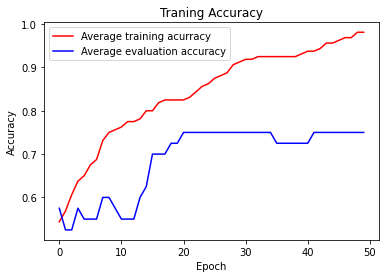

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception
# last update by BZ, June 30, 2021

import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from os import listdir
import pandas as pd

# 1. Load model
net = models.resnet50(pretrained=True)
finalconv_name = 'layer4'

# 2. Freeze the training for all layers
# Obs. This step only applies for transfer learning, if it's not your case just ignore it
for param in net.parameters():
    param.requires_grad = False

# 3. Update output to match number of classes
num_feats = net.fc.in_features
net.fc = nn.Linear(num_feats, 2)

# 4. Create transforms for the data
# Obs. Normalization is encouraged if using a pretrained model, the values correspond to the
# ImageNet dataset mean and standard deviations of each color channel. The pretraining was applied
# using this values, but hey can be changed to values that best suits your case. 
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# 5. Create dataset. This type can be found in the file Dataset.py of this package 
# and gets the path to a csv with the list of the images file names and the base path to the folder of the
# images. If you don't have the csv already, you can use the 'createFolderContentCsv' function
# from the file FileHandling.py. 
benigno = ['/content/Dataset/benigno/' + file for file in listdir('Dataset/benigno')]
maligno = ['/content/Dataset/maligno/' + file for file in listdir('Dataset/maligno')]
images = benigno + maligno
#images = ['/content/Dataset/' + file for file in listdir('Dataset')]
#data = ImageDataset('/content/Dataset/images_csv.csv', "Dataset", 2, transform=trans)
#images.remove('/content/Dataset/benigno/.ipynb_checkpoints')

classif = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

database = pd.DataFrame({'nome': images, 'classificacao': classif})

database.to_csv('database.csv', header = False, index=False)

#data = ImageDataset("/content/sample_data/dataset/csv_file.csv", "/content/sample_data/dataset", 2, transform=trans)
data = ImageDataset("/content/database.csv", "/content", 2, transform=trans)

# input image
#LABELS_file = '/content/imagenet-simple-labels.json'
#image_file = '/content/dataset/dobermann.png'

# 6. Specify error and optimization functions 
crit = nn.MSELoss()
opt = optim.SGD(net.parameters(), lr=0.001)

# 7. Call the training function
#trainedModel = cnn.trainCrossValidation(net,data,5,crit,opt,50, plotAcc = True)
trainedModel = trainCrossValidation(net,data,5,crit,opt,50,True)
#net.eval()
trainedModel.eval()

#networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
#Rede neural escolhida: ResNet-50
#net = models.resnet50(pretrained=True)
#finalconv_name = 'layer4'



CAM:


In [ ]:
import json

LABELS_file = '/content/labels.json'

numero = 1

for image_path in images:
  #imagem = cv2.imread(image_path)
  imagem = Image.open(image_path)

  # hook the feature extractor
  features_blobs = []
  def hook_feature(module, input, output):
      features_blobs.append(output.data.cpu().numpy())

  net._modules.get(finalconv_name).register_forward_hook(hook_feature)

  # get the softmax weight
  params = list(net.parameters())
  # pega os pesos da última camada
  weight_softmax = np.squeeze(params[-2].data.numpy())

  def returnCAM(feature_conv, weight_softmax, class_idx):
      # generate the class activation maps upsample to 256x256
      size_upsample = (256, 256)
      bz, nc, h, w = feature_conv.shape
      output_cam = []
      for idx in class_idx:
          cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
          cam = cam.reshape(h, w)
          cam = cam - np.min(cam)
          cam_img = cam / np.max(cam)
          cam_img = np.uint8(255 * cam_img)
          output_cam.append(cv2.resize(cam_img, size_upsample))
      return output_cam


  normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )
  preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
  ])

  # load test image
  #img_pil = Image.open(image_file).convert('RGB')
  
  print(image_path)
  #img_pil = Image.open(imagem).convert('RGB')
  img_pil = imagem.convert('RGB')
  img_tensor = preprocess(img_pil)
  img_variable = Variable(img_tensor.unsqueeze(0))
  #logit = net(img_variable)
  logit = trainedModel(img_variable)

  # load the imagenet category list
  with open(LABELS_file) as f:
      classes = json.load(f)
  #classes = ["normal", "suspeito"]


  h_x = F.softmax(logit, dim=1).data.squeeze()
  probs, idx = h_x.sort(0, True)
  probs = probs.numpy()
  idx = idx.numpy()

  # output the prediction
  for i in range(0, 2):
      print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

  # generate class activation mapping for the top1 prediction
  CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

  # render the CAM and output
  print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
  img = cv2.imread(image_path)
  height, width, _ = img.shape
  #height, width, _ = imagem.shape
  heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
  #result = heatmap * 0.5 + img * 0.3
  result = heatmap * 0.5 + img * 0.3

  #Salva o Mapa de Classe de Ativação na pasta CAMs
  cv2.imwrite('/content/CAMs/CAM{}.jpg'.format(numero), result)
  numero = numero + 1

/content/Dataset/benigno/benigno (10).tif
0.530 -> normal
0.470 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (1).tif
0.583 -> normal
0.417 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (2).tif
0.513 -> normal
0.487 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (5).tif
0.501 -> suspeito
0.499 -> normal
output CAM.jpg for the top1 prediction: suspeito
/content/Dataset/benigno/benigno (9).tif
0.545 -> normal
0.455 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (8).tif
0.570 -> normal
0.430 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (12).tif
0.519 -> normal
0.481 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/benigno/benigno (15).tif
0.525 -> normal
0.475 -> suspeito
output CAM.jpg for the top1 prediction: normal
/content/Dataset/be

In [ ]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt


#result = cv2.imread('/content/dataset/dobermann.png')
#numero = 1
#for i in range(0,5):
#  cv2.imwrite('/content/CAMs/CAM{}.jpg'.format(numero), result)
#  numero = numero + 1